<a href="https://colab.research.google.com/github/sanjeetarya001/TimeSeriesdata/blob/main/FFT_complete_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Preperation and Analysis

### Importing Packages

In [ ]:
%%capture
!pip install darts

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel,NBEATSModel, NaiveSeasonal, NaiveDrift,ExponentialSmoothing,FFT
from darts.metrics import mape, rmse
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality ,plot_acf,stationarity_test_adf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression,GaussianLikelihood
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

### DataSet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/TFT_files/output.csv'
df4 = pd.read_csv(path)

In [ ]:
df4

,time,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,gen_hyd_pump
0,2014-12-31 23:00:00+00:00,65.41,50.10,"4,821.00","4,844.00","25,385.00",329.00,162.00,73.00,"1,035.00",863.00
1,2015-01-01 00:00:00+00:00,64.92,48.10,"4,755.00","5,196.00","24,382.00",328.00,158.00,71.00,"1,035.00",920.00
2,2015-01-01 01:00:00+00:00,64.48,47.33,"4,581.00","4,857.00","22,734.00",323.00,157.00,73.00,"1,036.00","1,164.00"
3,2015-01-01 02:00:00+00:00,59.32,42.27,"4,131.00","4,314.00","21,286.00",254.00,160.00,75.00,"1,036.00","1,503.00"
4,2015-01-01 03:00:00+00:00,56.04,38.41,"3,840.00","4,130.00","20,264.00",187.00,156.00,74.00,"1,036.00","1,826.00"
...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,77.02,68.85,"2,628.00","7,634.00","30,653.00",0.00,178.00,95.00,"1,027.00",1.00
35060,2018-12-31 19:00:00+00:00,76.16,68.40,"2,566.00","7,241.00","29,735.00",0.00,174.00,95.00,"1,027.00",1.00
35061,2018-12-31 20:00:00+00:00,74.30,66.88,"2,422.00","7,025.00","28,071.00",0.00,168.00,94.00,"1,028.00",50.00
35062,2018-12-31 21:00:00+00:00,69.89,63.93,"2,293.00","6,562.00","25,801.00",0.00,163.00,93.00,"1,028.00",108.00


In [ ]:
# datetime
df4["time"] = pd.to_datetime(df4["time"], utc=True, infer_datetime_format=True)
df4.set_index("time", inplace=True)

In [ ]:
f64cols = list(df4.dtypes[df4.dtypes == np.float64].index)
df4[f64cols] = df4[f64cols].applymap(np.float32)

In [ ]:
#df4 = df4[df4.index >= "2018-01-01 00:00:00+00:00"]

In [ ]:
print(len(df4))

35064


In [ ]:
fig = px.line(df4, x=df4.index, y='price', title='Time Series with Rangeslider')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

### Conversion to TimeSeries

In [ ]:
# create time series object for target variable
price = TimeSeries.from_series(df4["price"])

# check attributes of the time series
print("components:", price.components)
print("duration:",price.duration)
print("frequency:",price.freq)
print("frequency:",price.freq_str)
print("has date time index? (or else, it must have an integer index):",price.has_datetime_index)
print("deterministic:",price.is_deterministic)
print("univariate:",price.is_univariate)

components: Index(['price'], dtype='object', name='component')
duration: 1460 days 23:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [ ]:
len(price)

35064

In [ ]:
def plotsignal(ts,title_name):

  #Creating datafram from Timeseries
  cc=ts.pd_dataframe()

  fig = go.Figure([go.Scatter(x=cc.index, y=cc.price,name='Prediction')])
  fig.update_xaxes(rangeslider_visible=True)
  fig.update_layout(title_text = title_name)
  fig.update_xaxes(title_text="Time")
  fig.update_yaxes(title_text="Price")
  return fig.show()

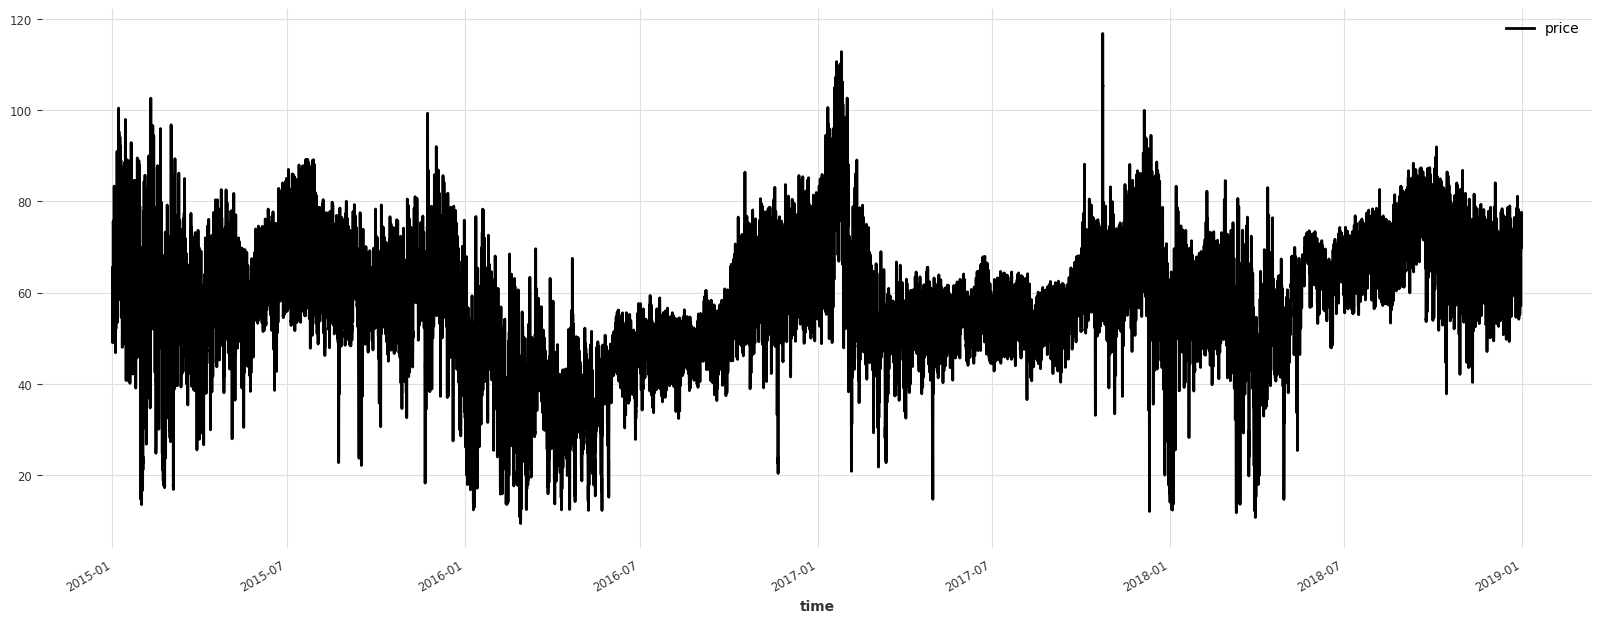

In [ ]:
# plt.figure(100, figsize=(20, 7))
# price.plot()
plotsignal()

###Seasonality Check

In [ ]:
MSEAS = 200
ALPHA = 0.05
mseas=MSEAS
seasonality = []
for m in range(2, MSEAS):
    is_seasonal, mseas = check_seasonality(price, m=m, alpha=ALPHA, max_lag=MSEAS)
    if is_seasonal:
       seasonality.append(mseas)
      #  break
print(seasonality)
print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {} hours'.format(mseas))

[12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192]
seasonal? False


Trend and seasonal components

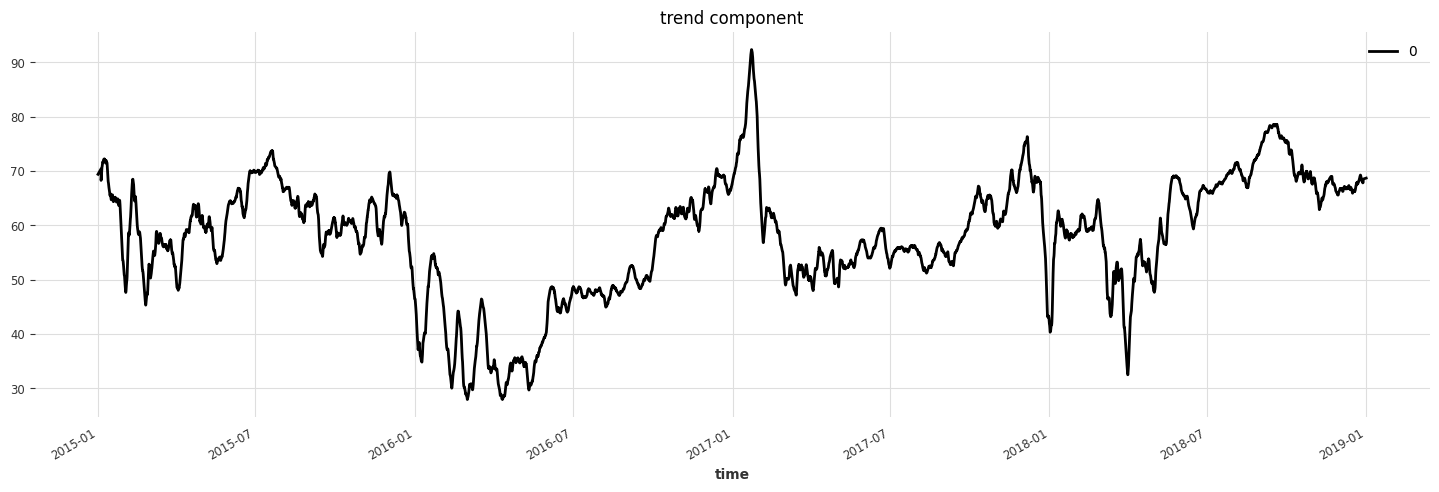

In [ ]:
trend, seas = extract_trend_and_seasonality(ts=price, freq=168)

plt.figure(100, figsize=(18, 5))
trend.plot()
plt.title("trend component");

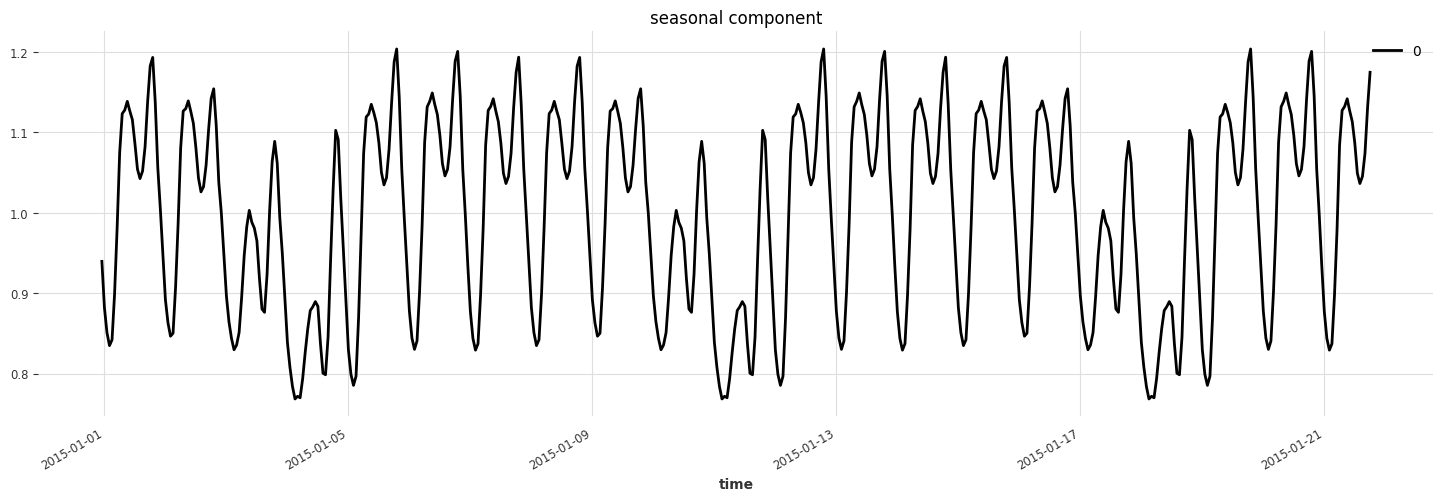

In [ ]:
plt.figure(100, figsize=(18, 5))
seas.head(500).plot()
plt.title("seasonal component");

### Covariates

In [ ]:
# create time series object for the feature columns
df_cov = df4.loc[:, df4.columns != "price"]
covariates = TimeSeries.from_dataframe(df_cov)

In [ ]:
covariates.columns

Index(['price_dayahead', 'gen_coal', 'gen_gas', 'load_actual', 'gen_lig',
       'gen_oil', 'gen_oth_renew', 'pressure_Barcelona', 'gen_hyd_pump'],
      dtype='object', name='component')

In [ ]:
covariates.n_components

9

In [ ]:
# rescale the covariates: fit on the training set
scaler = Scaler()
scaler.fit(covariates)
covariates = scaler.transform(covariates)

### Train/Test Split (Target Variable)

In [ ]:
target_train, target_test = price.split_after(0.9)
print("training start:", target_train.start_time())
print("training end:", target_train.end_time())
print("training duration:",target_train.duration)
print("test start:", target_test.start_time())
print("test end:", target_test.end_time())
print("test duration:", target_test.duration)

training start: 2014-12-31 23:00:00
training end: 2018-08-07 19:00:00
training duration: 1314 days 20:00:00
test start: 2018-08-07 20:00:00
test end: 2018-12-31 22:00:00
test duration: 146 days 02:00:00


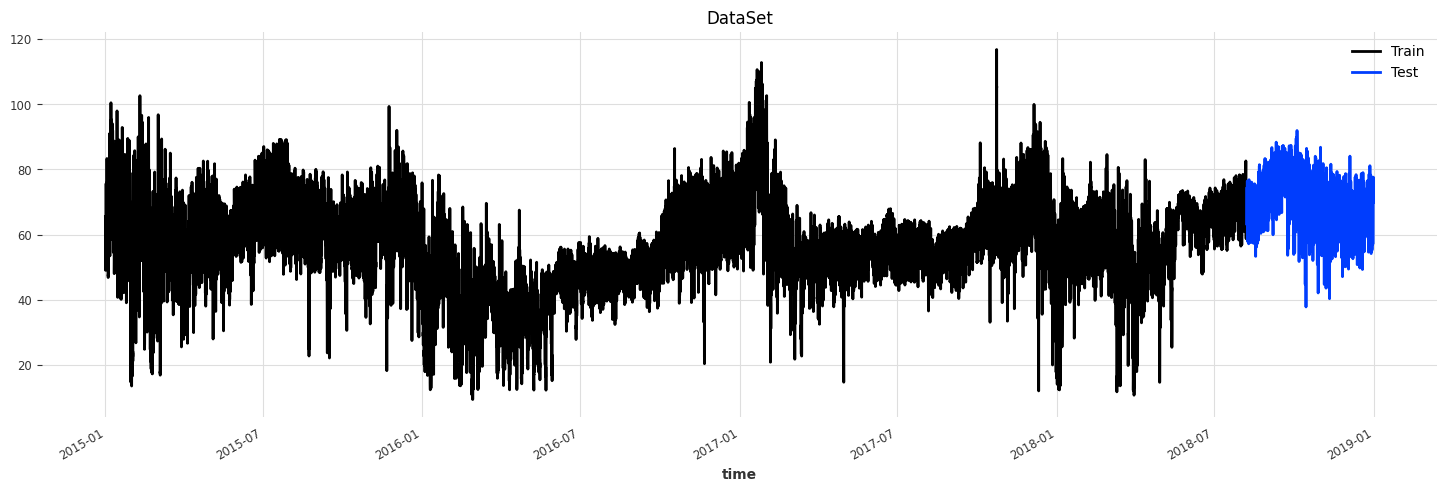

In [ ]:
plt.figure(100, figsize=(18, 5))
target_train.plot(label="Train")
target_test.plot(label="Test")
plt.title("DataSet");

### Scaling (Between 0 and 1)

In [ ]:
scalerPrice = Scaler()
scalerPrice.fit(target_train)
trans_target_train = scalerPrice.transform(target_train)
trans_target_test = scalerPrice.transform(target_test)
trans_price = scalerPrice.transform(price)

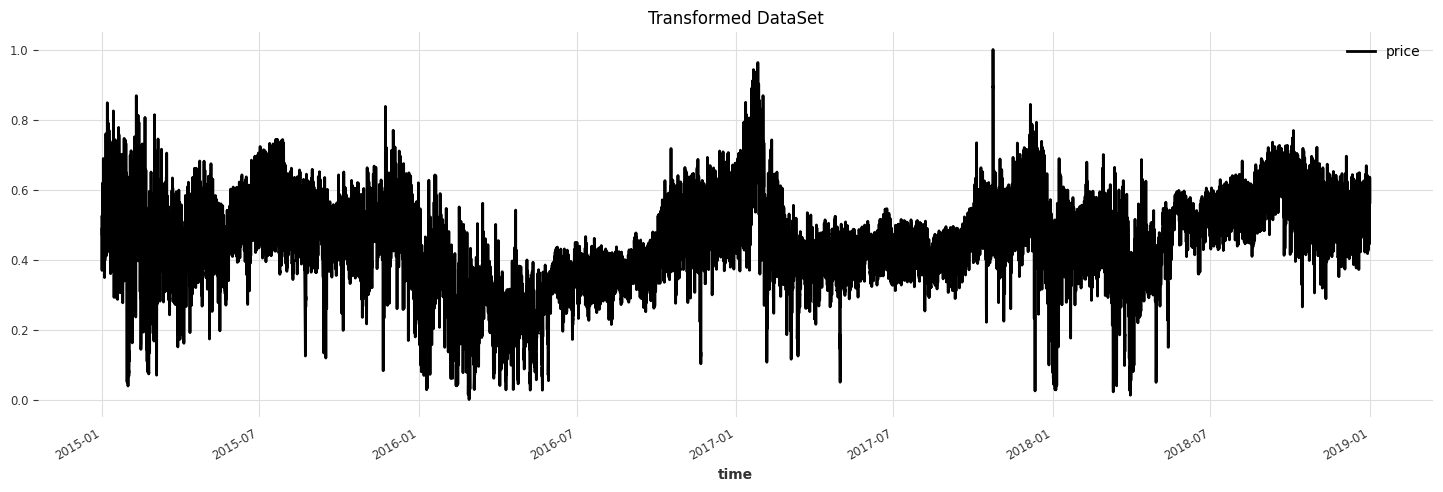

In [ ]:
plt.figure(100, figsize=(18, 5))
trans_price.plot()
plt.title("Transformed DataSet");

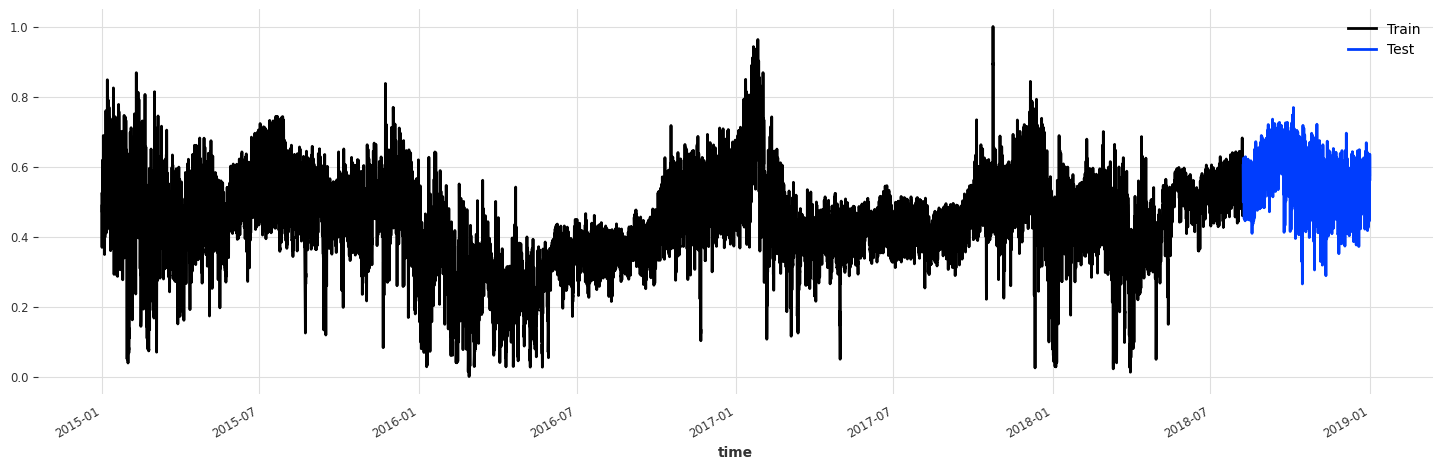

In [ ]:
plt.figure(100, figsize=(18, 5))
trans_target_train.plot(label="Train")
trans_target_test.plot(label="Test")

In [ ]:
# Spliting the train dataset into final_train and validation set
final_train , final_val = trans_target_train.split_after(0.8)
print("training start:", final_train.start_time())
print("training end:", final_train.end_time())
print("training duration:",final_train.duration)
print("Validation start:", final_val.start_time())
print("Validation end:", final_val.end_time())
print("Validation duration:", final_val.duration)

training start: 2014-12-31 23:00:00
training end: 2017-11-17 19:00:00
training duration: 1051 days 20:00:00
Validation start: 2017-11-17 20:00:00
Validation end: 2018-08-07 19:00:00
Validation duration: 262 days 23:00:00


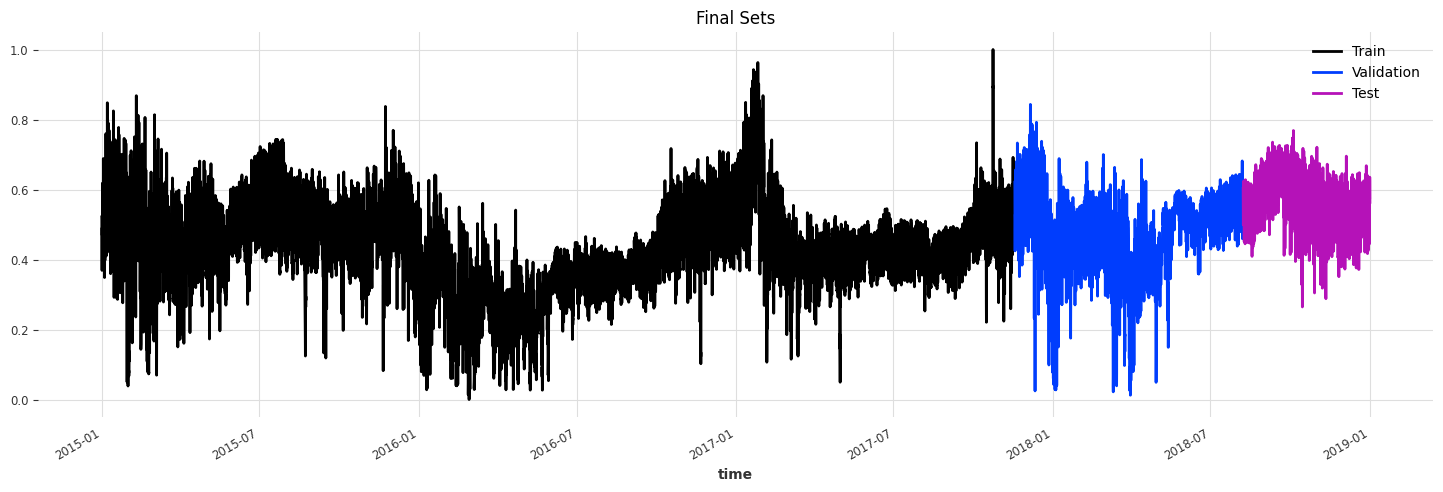

In [ ]:
plt.figure(100, figsize=(18, 5))
final_train.plot(label="Train")
final_val.plot(label = 'Validation')
trans_target_test.plot(label="Test")
plt.title("Final Sets");

# FFT Model

### Instantiating

In [ ]:
Fmodel = FFT(nr_freqs_to_keep=20)

### Training

In [ ]:
Fmodel.fit(final_train)

FFT(nr_freqs_to_keep=20, required_matches=None, trend=None, trend_poly_degree=3)

### Predicting

In [ ]:
# testing: generate predictions
predicted_horizon = Fmodel.predict(len(final_val)+30*24)

### Result Analysis

In [ ]:
print(mape(final_val,predicted_horizon))

35.29989625661748


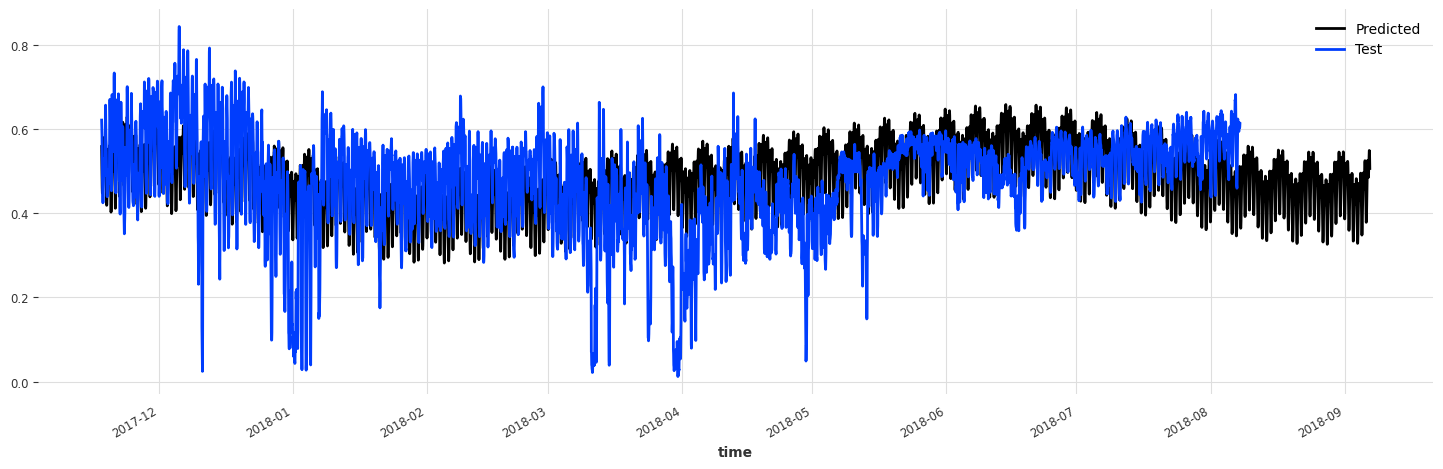

In [ ]:
plt.figure(100, figsize=(18, 5))
predicted_horizon.plot(label = 'Predicted')
final_val.plot(label = 'Test')

In [ ]:
# Transforming the data back to original scale

In [ ]:
val = scalerPrice.inverse_transform(final_val)
horizon = scalerPrice.inverse_transform(predicted_horizon)
print(mape(val,horizon))

21.125064341488386


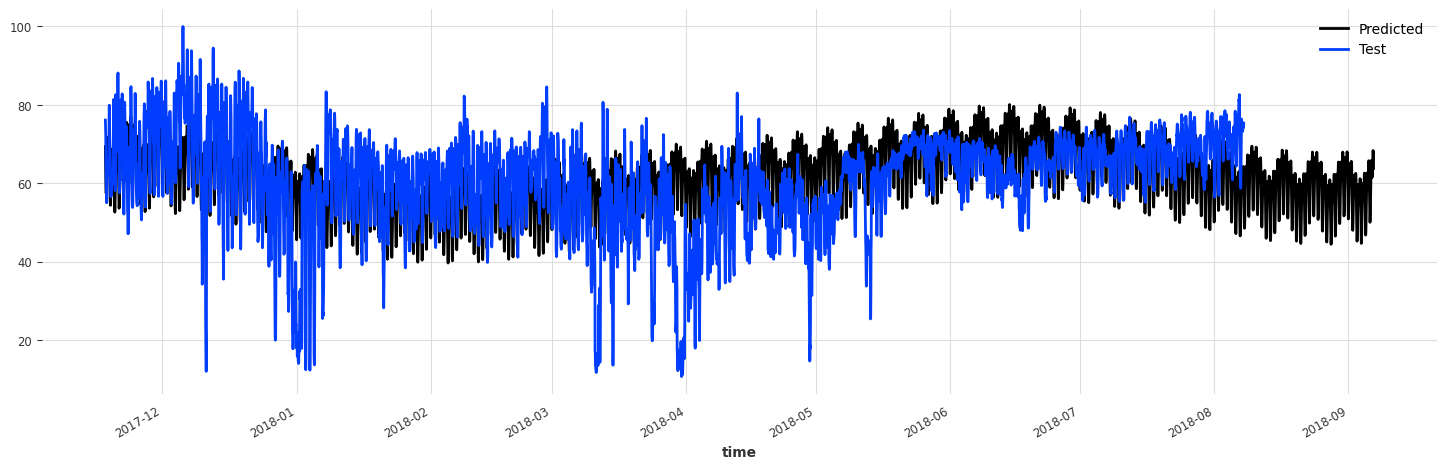

In [ ]:
plt.figure(100, figsize=(18, 5))
horizon.plot(label = 'Predicted')
val.plot(label = 'Test')

# Tunning

## Getting New Parameters Using optuna

### Importing Packages

In [ ]:
%%capture
!pip install -U optuna

In [ ]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)
import torch
import random
from tqdm.notebook import tqdm
from pytorch_lightning.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback

class PyTorchLightningPruningCallback(Callback):
    """PyTorch Lightning callback to prune unpromising trials.
    See `the example <https://github.com/optuna/optuna-examples/blob/
    main/pytorch/pytorch_lightning_simple.py>`__
    if you want to add a pruning callback which observes accuracy.
    Args:
        trial:
            A :class:`~optuna.trial.Trial` corresponding to the current evaluation of the
            objective function.
        monitor:
            An evaluation metric for pruning, e.g., ``val_loss`` or
            ``val_acc``. The metrics are obtained from the returned dictionaries from e.g.
            ``pytorch_lightning.LightningModule.training_step`` or
            ``pytorch_lightning.LightningModule.validation_epoch_end`` and the names thus depend on
            how this dictionary is formatted.
    """

    def __init__(self, trial: optuna.trial.Trial, monitor: str) -> None:
        super().__init__()

        self._trial = trial
        self.monitor = monitor

    def on_validation_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        # When the trainer calls `on_validation_end` for sanity check,
        # do not call `trial.report` to avoid calling `trial.report` multiple times
        # at epoch 0. The related page is
        # https://github.com/PyTorchLightning/pytorch-lightning/issues/1391.
        if trainer.sanity_checking:
            return

        epoch = pl_module.current_epoch

        current_score = trainer.callback_metrics.get(self.monitor)
        if current_score is None:
            message = (
                "The metric '{}' is not in the evaluation logs for pruning. "
                "Please make sure you set the correct metric name.".format(self.monitor)
            )
            warnings.warn(message)
            return

        self._trial.report(current_score, step=epoch)
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(epoch)
            raise optuna.TrialPruned(message)

### Objective Function

In [ ]:
def objective(trial):

    # reproducibility
    torch.manual_seed(42)

    # Other hyperparameters
    nr_freqs_to_keep = trial.suggest_int("nr_freqs_to_keep",5,25)
    trend = trial.suggest_categorical("trend",['poly','exp',None])
    trend_poly_degree = trial.suggest_int("trend_poly_degree", 1, 4)
    # lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)

    # throughout training we'll monitor the validation loss for early stopping

    # build and train the NBEATS model with these hyper-parameters:
    Fmodel = FFT(
                  nr_freqs_to_keep=nr_freqs_to_keep,
                  trend = trend,
                  trend_poly_degree = trend_poly_degree
                 )
    Fmodel.fit(final_train)
    # testing: generate predictions
    # testing: generate predictions
    predicted_horizon = Fmodel.predict(len(final_val))
    # Evaluate how good it is on the validation set

    mape_val = mape(final_val, predicted_horizon, n_jobs=-1, verbose=True)


    return mape_val if mape_val != np.nan else float("inf")

### Study optimization

In [ ]:
%%capture
study = optuna.create_study(direction="minimize")
#study.optimize(objective, timeout=300, callbacks=[print_callback])

# We could also have used a command as follows to limit the number of trials instead:
study.optimize(objective, n_trials=500)

In [ ]:
# Finally, print the best value and best hyperparameters:
print(f"\nBest value: {study.best_value}, Best params: {study.best_trial.params}")


Best value: 34.57408837354611, Best params: {'nr_freqs_to_keep': 17, 'trend': None, 'trend_poly_degree': 1}


## After Model Tunning

### Instantiating

In [ ]:
Fmodel = FFT(
                  nr_freqs_to_keep=17,
                  trend = None,
                  trend_poly_degree = 1
            )

### Training

In [ ]:
Fmodel.fit(final_train)

FFT(nr_freqs_to_keep=17, required_matches=None, trend=None, trend_poly_degree=1)

### Predicting

In [ ]:
# testing: generate predictions
predicted_horizon = Fmodel.predict(len(final_val)+30*24)

### Result Analysis

In [ ]:
print(mape(final_val,predicted_horizon))

34.57408837354611


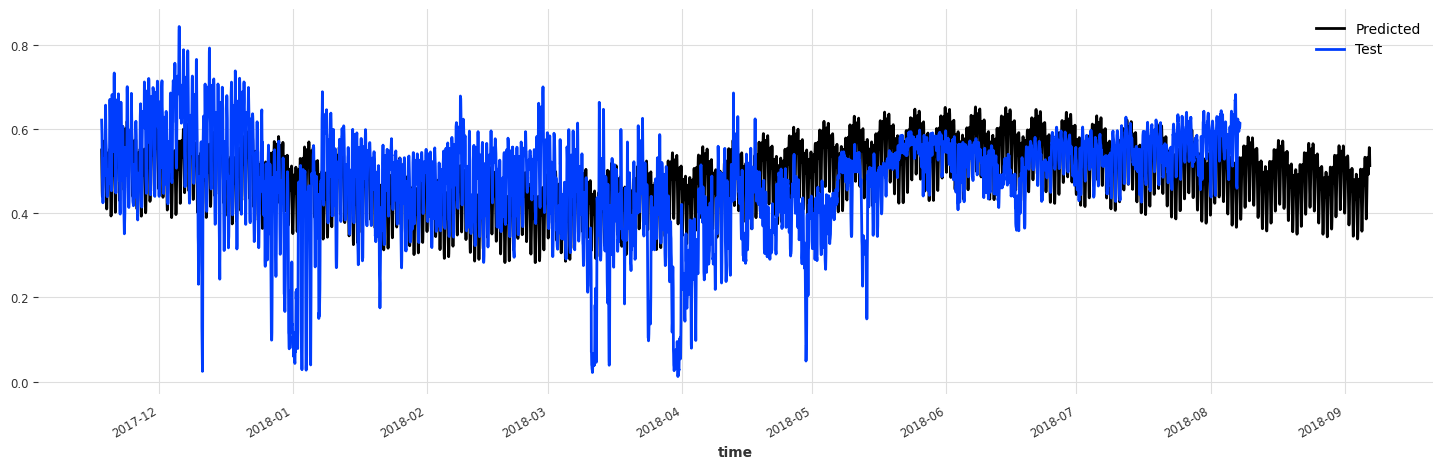

In [ ]:
plt.figure(100, figsize=(18, 5))
predicted_horizon.plot(label = 'Predicted')
final_val.plot(label = 'Test')

In [ ]:
# Transforming the data back to original scale

In [ ]:
val = scalerPrice.inverse_transform(final_val)
horizon = scalerPrice.inverse_transform(predicted_horizon)
print(mape(val,horizon))

20.758161476544075


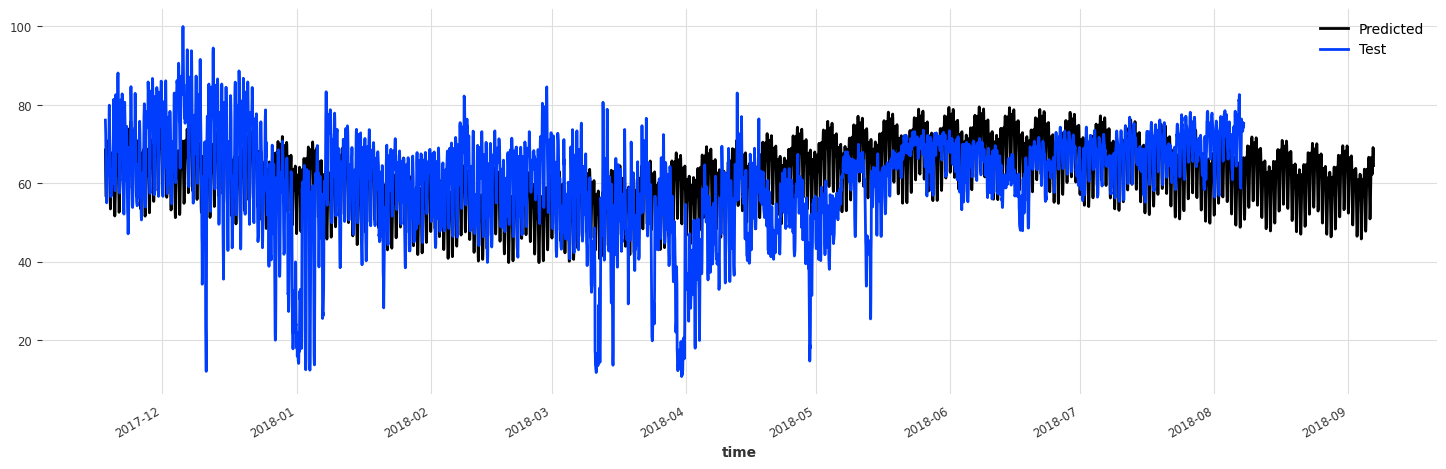

In [ ]:
plt.figure(100, figsize=(18, 5))
horizon.plot(label = 'Predicted')
val.plot(label = 'Test')

## Grid Search

In [ ]:
# randomized gridsearch
parameters = {  "input_chunk_length":[72, 168],
                "output_chunk_length":[24,48],
                "hidden_size":[32, 64],
                "lstm_layers":[1],
                "num_attention_heads":[2, 3],
                "dropout":[0.1],
                "batch_size":[32, 64],
                "n_epochs":[3]
              }

res = TFTModel.gridsearch(
                            parameters=parameters,
                            series=final_train,
                            future_covariates=covariates,
                            val_series=final_val,
                            start=0.5,                 # starting point in training set
                            last_points_only=False,
                            metric=mape,
                            reduction=np.mean,
                            n_jobs=N_JOBS,
                            n_random_samples=0.99,      # % of full search space to evaluate
                            verbose=True
                          )


In [ ]:
bestmodel , dict_bestparams,value = res

In [ ]:
dict_bestparams

{'input_chunk_length': 168,
 'output_chunk_length': 24,
 'hidden_size': 64,
 'lstm_layers': 1,
 'num_attention_heads': 2,
 'dropout': 0.1,
 'batch_size': 64,
 'n_epochs': 3}

In [ ]:
bestmodel._model_params

OrderedDict([('hidden_size', 64),
             ('lstm_layers', 1),
             ('num_attention_heads', 2),
             ('full_attention', False),
             ('feed_forward', 'GatedResidualNetwork'),
             ('dropout', 0.1),
             ('hidden_continuous_size', 8),
             ('categorical_embedding_sizes', None),
             ('add_relative_index', False),
             ('loss_fn', None),
             ('likelihood', None),
             ('norm_type', 'LayerNorm'),
             ('use_static_covariates', True),
             ('input_chunk_length', 168),
             ('output_chunk_length', 24),
             ('batch_size', 64),
             ('n_epochs', 3)])

In [ ]:
# training
bestmodel.fit( series=final_train,
               future_covariates=covariates,
               past_covariates=covariates,
               val_series=final_val,
               val_future_covariates=covariates,
               verbose=True
             )

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

TFTModel(hidden_size=64, lstm_layers=1, num_attention_heads=2, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=168, output_chunk_length=24, batch_size=64, n_epochs=3)

In [ ]:
pred =  bestmodel.predict(len(final_val),future_covariates = covariates)
MAPE = "MAPE after randomized gridsearch: {:.2f}%".format(mape(final_val, pred))